- 事故種別(基本)名について
  "医師搬送"は除外しても良さそう(医師を運んだだけ？、傷病名の記載もない)
  "転院搬送"も関係なさそう

- 収容機関名
  "不搬送"はいらないのでは？
  →不搬送を除外すると、傷病名が空欄は無くなったし、事故種別の医師搬送もなくなった

- 傷病名(大, 中, 小)分類(国)名
  一旦いらないかな

In [1]:
import os
import sys

sys.path.append(os.path.join(os.path.abspath(''), '../src/'))
import pandas as pd

def clean_data(df):
    # 次の列の種類をstringに変更する: '覚知日付(元号年月日)'
    df = df.astype({'覚知日付(元号年月日)': 'string'})
    df = df.astype({'覚知日付(元号)名': 'string'})
    df = df.astype({'覚知日付(年)': 'string'})
    df = df.astype({'覚知日付(月)': 'string'})
    df = df.astype({'覚知日付(日)': 'string'})
    df = df.astype({'覚知時刻(時)': 'string'})
    df = df.astype({'覚知時刻(分)': 'string'})

    df["datestr"] = df["覚知日付(元号)名"] + df["覚知日付(年)"] +"年" + df["覚知日付(月)"] +"月"+ df["覚知日付(日)"]+"日" \
                    + " " + df["覚知時刻(時)"] + ":" + df["覚知時刻(分)"]
    df.drop(['覚知日付(元号年月日)','覚知日付(元号)名','覚知日付(年)',
             '覚知日付(月)','覚知日付(日)','覚知時刻(時)','覚知時刻(分)'],axis=1,inplace=True)
    import jp_datetime
    df["datetime"] = df["datestr"].apply(lambda x: 
                                         jp_datetime.parse_date(x,'%g%e年%m月%d日 %H:%M')
                                         )
    df.drop(['datestr'],axis=1,inplace=True)
    df = df.reindex(['datetime','出場隊名', '事故種別(基本)名', '覚知→現着(所要時間)', '覚知→病着(所要時間)', '年齢(歳)', '年齢区分名',
       '性別名', '傷病程度名', '傷病名', '傷病名大分類(国)名', '傷病名中分類(国)名', '傷病名小分類(国)名',
       '収容機関名', '行政区別区分名'], axis=1)
    

    # 病院に実際に来る場合を対象にしたいので、不搬送を除去
    df = df[df['収容機関名'] != "不搬送"]

    # 列を削除: '傷病名大分類(国)名'
    df = df.drop(columns=['傷病名大分類(国)名'])
    df = df.drop(columns=['傷病名中分類(国)名'])
    df = df.drop(columns=['傷病名小分類(国)名'])

    # count用に列を追加
    df["count"] = 1

    # 列で並べ替えます: 'datetime' (昇順)
    df = df.sort_values(['datetime'], ignore_index=True)
    
    return df

# excel形式のデータ読み込み
df = pd.concat(
    [pd.read_excel(r'../input/01_令和元年.xlsx'),
    pd.read_excel(r"../input/02_令和２年.xlsx"),
    pd.read_excel(r"../input/03_令和３年.xlsx"),
    pd.read_excel(r"../input/04_令和４年.xlsx"),
    pd.read_excel(r"../input/05_令和５年.xlsx")]
)

df_clean = clean_data(df.copy())
df_clean.head(3)

,datetime,出場隊名,事故種別(基本)名,覚知→現着(所要時間),覚知→病着(所要時間),年齢(歳),年齢区分名,性別名,傷病程度名,傷病名,収容機関名,行政区別区分名,count
0,2019-01-01 00:07:00,浜北救急隊,急病,8,40.0,68.0,高齢者,男,軽症,意識消失発作,浜松医大病院,浜北区,1
1,2019-01-01 00:19:00,高台救急隊,急病,8,23.0,4.0,乳幼児,男,軽症,熱性痙攣,浜松医大病院,中区,1
2,2019-01-01 00:21:00,中救急隊,転院搬送,6,31.0,6.0,乳幼児,女,中等症,インフルエンザ、嘔吐,浜松医大病院,中区,1


In [17]:
df_clean.傷病名.to_csv("../output/傷病名一覧.csv",index=None)

<Axes: xlabel='datetime'>

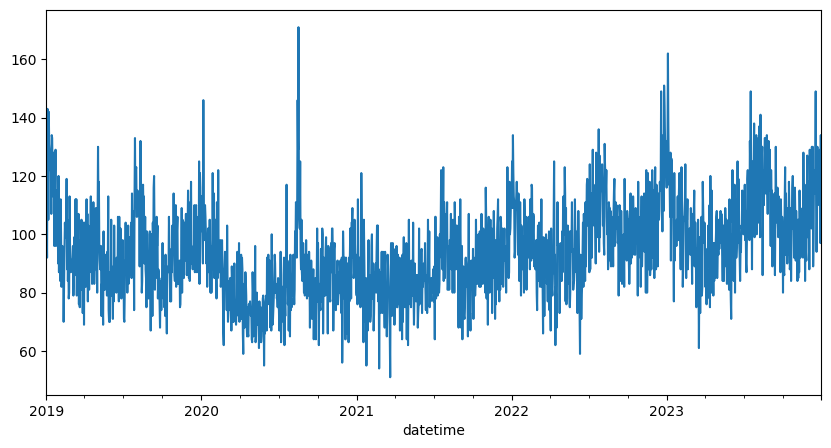

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL # STL分解
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1,1,1)
df_clean.groupby(pd.Grouper(key="datetime", freq="D")).sum()["count"].plot(ax=ax)   

In [11]:
# stl分解してみる
stl = STL(df_clean.groupby(pd.Grouper(key="datetime", freq="D")).sum()["count"], period=7)
result = stl.fit()


In [7]:
result.seasonal

datetime
2019-01-01     8.156488
2019-01-02    -9.396362
2019-01-03   -16.678610
2019-01-04    12.520883
2019-01-05     9.715338
                ...    
2023-12-27    -8.515538
2023-12-28     3.316042
2023-12-29    -7.530800
2023-12-30     7.291247
2023-12-31    -4.640499
Freq: D, Name: season, Length: 1826, dtype: float64

In [8]:
result.trend

datetime
2019-01-01    114.144203
2019-01-02    116.160210
2019-01-03    118.043490
2019-01-04    119.792823
2019-01-05    121.439099
                 ...    
2023-12-27    117.650876
2023-12-28    117.821567
2023-12-29    117.949055
2023-12-30    117.988261
2023-12-31    117.927481
Freq: D, Name: trend, Length: 1826, dtype: float64

<Axes: xlabel='datetime'>

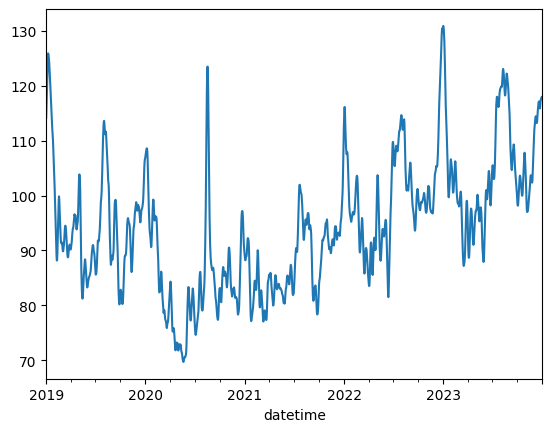

In [10]:
result.trend.plot()

In [9]:
result.resid

datetime
2019-01-01    -2.300691
2019-01-02    -3.763848
2019-01-03    -9.364880
2019-01-04    10.686294
2019-01-05     4.845564
                ...    
2023-12-27    11.864662
2023-12-28     7.862392
2023-12-29   -13.418255
2023-12-30     8.720492
2023-12-31   -10.286982
Freq: D, Name: resid, Length: 1826, dtype: float64